# TED Talk Topic Classification

## Data Preprocessing

### Reading in the data and labelling observations

Standard imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

Merge transcripts.csv with ted_main.csv

In [2]:
def read_in_merged_data(path_to_tedtalks=''):
    """ Merge transcripts.csv with ted_main.csv

    # Arguments:
        path_to_data : str
            Specify the path to the `tedtalks` folder containing the data

    # Returns:
        df_merged : pd.DataFrame
            A data frame containing the merged transcripts.csv and ted_main.csv files
    """

    # Read in the data
    df_main = pd.read_csv(path_to_tedtalks + 'tedtalks/ted_main.csv')
    df_transcripts = pd.read_csv(path_to_tedtalks + 'tedtalks/transcripts.csv')

    # Merge data frames on `url`, since some ted talks in `ted_main.csv` do not have transcripts in `transcripts.csv`
    df_merged = df_main.merge(df_transcripts, how="inner", on="url")

    return df_merged

df_merged = read_in_merged_data()

Extract T/E/D label for each TED talk transcript

In [3]:
def extract_label(tags):
    """Returns the T/E/D label for a TED talk based on its keyword tags,
       where T = Technology, E = Entertainment, D = Design.

    # Parameters:
        tags: str, containing a list of keyword tags for a TED Talk.
                Example input: "['computers', 'design', 'technology']"
    
    # Returns:
        label: str, T/E/D label
                Options: "Other", "T", "E", "D", "TE", "TD", "ED" and "TED"
    """
    
    # Cast tags from string to a list e.g. "['technology', 'design']" to ['technology', 'design']
    tags = eval(tags) 

    # Cast all tags to lower case 
    tags = [tag.lower() for tag in tags] 

    # Extract which T/E/D categories are contained in the keyword tags
    label_categories = ['technology', 'entertainment', 'design'] 
    ted_category = set(label_categories).intersection(tags)  

    # Sort the extracted T/E/D categories in T-E-D order i.e. descending order
    ted_category = sorted(list(ted_category), reverse = True) 

    # Extract and capitalize the first letter of each T/E/D component
    ted_category = [c[0].upper() for c in ted_category] 

     # Cast the list to a string e.g. ["T", "D"] to "TD"
    ted_category = "".join(ted_category)

    # If no T/E/D category, label the talk as "other"
    label = "Other" if ted_category == "" else ted_category

    return label

df_merged["label"] = df_merged["tags"].apply(extract_label)

### Brief data exploration

Summary statistics: 

*(Note the number of words per sample is an approximation obtained by splitting the text by white space)*

In [4]:
print(f"Number of samples: {len(df_merged)}")
print(f"Number of classes: {df_merged['label'].nunique()}")
print(f"Median number of words per sample: {round(np.median([len(transcript.split()) for transcript in list(df_merged['transcript'])]))}")
print(f"Min number of words per sample: {np.min([len(transcript.split()) for transcript in list(df_merged['transcript'])])}")
print(f"Max number of words per sample: {np.max([len(transcript.split()) for transcript in list(df_merged['transcript'])])}")

Number of samples: 2467
Number of classes: 8
Median number of words per sample: 2028.0
Min number of words per sample: 1
Max number of words per sample: 9044


Plot distribution of number of words per sample: 

*(Notice there are some very short transcripts – typically corresponding to musical performances not involving speaking)*

In [5]:
# Use LaTEX font
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Palatino']})

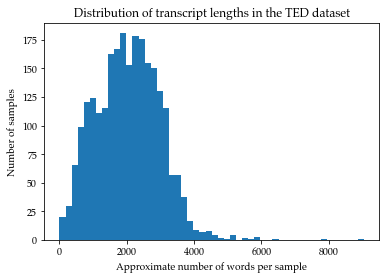

In [6]:
def plot_sample_length_distribution(df):
    """Plots a histogram with the distribution of the transcript lengths stored in a data frame.
    
    # Parameters:
        df: pd.DataFrame, a data frame containing a "transcript" column

    # Raises:
        AssertionError : if "transcript" is not a column in `df` 
    """
    assert "transcript" in df.columns

    plt.hist([len(transcript.split()) for transcript in list(df['transcript'])], 50)
    plt.ylabel("Number of samples")
    plt.xlabel("Approximate number of words per sample")
    plt.title("Distribution of transcript lengths in the TED dataset")

plot_sample_length_distribution(df_merged)

Plot distribution of labels

*(Notice the high class imbalance)*

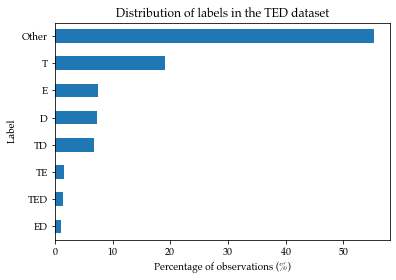

In [7]:
def plot_y_distribution(df, percentages=False):
    """Plots a horizontal bar graph with the distribution of the labels in a data frame.
    
    # Parameters:
        df: pd.DataFrame, a data frame containing a "label" column
        percentages: bool, whether to plot the proprtion of observations a given label
                            corresponds to, or just the raw counts

    # Raises:
        AssertionError : if "label" is not a column in `df` 
    """
    assert "label" in df.columns

    if percentages:
        (df["label"].value_counts()/len(df)*100.0).sort_values().plot.barh()
        plt.xlabel("Percentage of observations (%)")
    else:
        df["label"].value_counts().sort_values().plot.barh()
        plt.xlabel("Number of observations")

    plt.ylabel("Label")
    plt.title("Distribution of labels in the TED dataset")

#     plt.savefig(f"DistributionOfLabels.png", dpi=300)
    
plot_y_distribution(df_merged, True)

### Train-validation-test split

In [8]:
from sklearn.model_selection import train_test_split

def train_val_test_split(df, random_state = 42, validation_set_size = 0.2, test_set_size = 0.2):
    """Splits a data frame into train, validation and test sets – stratified according to
      label proportions.

    # Parameters:
        df: pd.DataFrame, a data frame containing a "transcript" and "label" column
        random_state: int, for reproducibility
        validation_set_size: int, the absolute size of the validation set to create from `df`
                              Default: 0.2 – 20% of the 2467 observations
        test_set_size: int, the absolute size of the test set to create from `df`
                              Default: 0.2 - 20% of the 2467 observations
        
    # Returns:
        df_train, df_val, df_test: pd.DataFrame
            `df` split into train, validation and test sets with "transcript"
            and "label" columns.

    # Raises:
        AssertionError : if either "transcript" or "label" are not columns in `df` 
    """
    assert "transcript" in df.columns and "label" in df.columns

    # Keep only the "transcript" and "label" columns in `df_all`
    df_all = pd.DataFrame(df[["transcript", "label"]])

    # Extract 20% of observations randomly for the validation set,
    # but stratify on the "label" column to preserve label proportions
    df_train, df_val = train_test_split(df_all, 
                                        test_size=validation_set_size,
                                        random_state=random_state,
                                        stratify=df_all["label"])

    # Extract 20% of observations randomly for the test set,
    # but stratify on the "label" column to preserve label proportions
    df_train, df_test = train_test_split(df_train, 
                                        test_size=test_set_size / (1 - validation_set_size),
                                        random_state=random_state,
                                        stratify=df_train["label"])
    
    return df_train, df_val, df_test

df_train, df_val, df_test = train_val_test_split(df_merged)
len(df_train), len(df_val), len(df_test)

(1479, 494, 494)

### Encoding model input (bag-of-words approach) and output representations (integer encoded labels)

Map/encode the labels to integers in the range `[0, num_classes-1]`

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

def encode_labels(df_train, df_val, df_test):
  """
  # Parameters:
      df_train, df_val, df_test: pd.DataFrame
          Data frames containing a "label" column to encode, 
          where the "label" column consists of strings.
      
  # Returns:
      y_train, y_val, y_test: np.ndarray of shape (n_obs,)
          Integer encoded response for training, validation, and testing.
      label_tokenizer: tf.keras.preprocessing.text.Tokenizer
          Used later to map integer encodings back to the string labels.

  # Raises:
      AssertionError : if "label" is not a column in `df_train`,
                        `df_val` or `df_test`
  """
  assert all("label" in df.columns for df in [df_train, df_val, df_test])

  # Fit the label tokenizer on the training data      
  label_tokenizer = Tokenizer()
  label_tokenizer.fit_on_texts(df_train['label'])

  # Convert from strings ("Other","T", "E", ... "TED") to integers in the range [1, 8]
  y_train = np.array(label_tokenizer.texts_to_sequences(df_train['label']))
  y_val = np.array(label_tokenizer.texts_to_sequences(df_val['label']))
  y_test = np.array(label_tokenizer.texts_to_sequences(df_test['label']))

  # Subtract 1 to cast encoded labels from range [1, 8] to range [0, 7].
  y_train, y_val, y_test = y_train - 1, y_val - 1, y_test - 1

  # Flatten to np.ndarray of shape (n_obs,)
  y_train, y_val, y_test = y_train.flatten(), y_val.flatten(), y_test.flatten()

  return y_train, y_val, y_test, label_tokenizer

y_train, y_val, y_test, label_tokenizer = encode_labels(df_train, df_val, df_test)

Tokenize / vectorize transcripts using TF-IDF bag-of-words approach

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def vectorize_transcripts(df_train, df_val, df_test, y_train, top_k_features=20000):
    """Tokenize and then vectorize the transcripts using the TF-IDF approach.

    # Parameters:
      df_train, df_val, df_test: pd.DataFrame
          Data frames containing a "transcript" column to encode, 
          where the "transcript" column consists of text strings.
      top_k_features: int
          The number of n-grams to keep for the bag-of-words.
          Only the `top_k_features` most important features will
          be retained.
      y_train: np.ndarray of shape (n_train,)
          Integer encoded labels for the training data, used
          for feature importance for choosing which tokens to retain.

    # Returns:
      X_train, X_val, X_test: scipy.sparse.csr.csr_matrix of shape (n_obs, top_k_features)
          Sparse matrices (to store efficiently) with the TF-IDF vectorized transcripts.
      transcript_vectorizer: sklearn.feature_extraction.text import TfidfVectorizer
          Based on training data, so can be used later to vectorize new data
      ngram_selector: sklearn.feature_selection.SelectKBest  
          Based on training data, so can be used later to select 
          the same 20000 best n-grams for new data  

    # Raises:
      AssertionError : if "transcript" is not a column in `df_train`,
                        `df_val` or `df_test`
    """
    assert all("transcript" in df.columns for df in [
               df_train, df_val, df_test])

    # Construct the TF-IDF vectorizer, considering both 1-grams and 2-grams as tokens
    transcript_vectorizer = TfidfVectorizer(ngram_range=(
        1, 2), strip_accents='unicode', min_df=2)

    # Learn vocabulary from training transcripts and vectorize training transcripts
    X_train = transcript_vectorizer.fit_transform(df_train["transcript"])

    # Vectorize validation and test transcripts
    X_val = transcript_vectorizer.transform(df_val["transcript"])
    X_test = transcript_vectorizer.transform(df_test["transcript"])

    # Select the 'top_k_features' most important n-grams in predicting the response,
    # using the chi-squared score as a measure of association between each
    # feature and the response in the training data.
    ngram_selector = SelectKBest(chi2, k=min(top_k_features, X_train.shape[1]))
    ngram_selector.fit(X_train, y_train)

    # Retain only the 'top_k_features' for each of the X matrices
    X_train = ngram_selector.transform(X_train).astype('float32')
    X_val = ngram_selector.transform(X_val).astype('float32')
    X_test = ngram_selector.transform(X_test).astype('float32')

    return X_train, X_val, X_test, transcript_vectorizer, ngram_selector

X_train, X_val, X_test, transcript_vectorizer, ngram_selector = vectorize_transcripts(df_train, df_val, df_test, y_train)

In [11]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1479, 20000), (1479,), (494, 20000), (494,), (494, 20000), (494,))

## Baseline

Always predict the most popular class

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [13]:
baseline_clf = DummyClassifier(strategy="most_frequent")
baseline_clf.fit(X_train, y_train)

train_pred = baseline_clf.predict(X_train)
val_pred = baseline_clf.predict(X_val)
test_pred = baseline_clf.predict(X_test)


baseline_val_f1 = f1_score(y_val, val_pred, average='macro')
baseline_val_acc = accuracy_score(y_val, val_pred)
print(f"Baseline validation F1 score: {baseline_val_f1*100:.2f}%")
print(f"Baseline accuracy: {baseline_val_acc*100:.2f}%")

Baseline validation F1 score: 8.90%
Baseline accuracy: 55.26%


## Model Building, Validation and Evaluation

### MLP

In [14]:
from tensorflow.keras import callbacks, models, layers

In [15]:
def create_MLP(hidden_layers=[128, 128], dropout=0.5, learning_rate=0.001, activation='relu', l2_penalty=0):
  """
  Create an MLP with the architecture and hyperparameters specified.
  """
  model = models.Sequential()

  num_layers = len(hidden_layers)

  # Hidden Layers
  for i in range(num_layers):
      if i != num_layers - 1:
        model.add(layers.Dense(hidden_layers[i], input_shape=(20000,)))
      else:
        model.add(layers.Dense(hidden_layers[i]))
      model.add(layers.Dropout(dropout))

  # Softmax output layer with 8 classes
  num_classes = 8
  model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(l2_penalty)))
  
  # Compile Model
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [16]:
def generate_MLP_params():
  """
  Generate the hyperparameters to be used for the MLP model using a 
  randomised grid search. 
  """
  # Set up search space for hyperparameters
  activations = ['relu']
  dropout = [0, 0.1, 0.25, 0.5, 0.5]
  learning_rate = [0.01, 0.005, 0.001, 0.0005]
  l2_penalty = [0, 0, 0.001, 0.01, 0.1]

  # Set up search space for architecture
  num_layers = [1, 2, 2, 3, 3, 4]
  hidden_nodes = [8, 16, 32, 64, 128, 256, 512]
  hidden_layers = random.choice(num_layers)
  model_shape = []
  for i in range(hidden_layers):
    model_shape.append(random.choice(hidden_nodes))

  # Create dictionary
  params = {}

  params['hidden_layers'] = model_shape
  params['learning_rate'] = random.choice(learning_rate)
  params['activation'] = random.choice(activations)
  params['dropout'] = random.choice(dropout)
  params['l2_penalty'] = random.choice(l2_penalty)

  return params

In [17]:
# Class weights used for weighting loss function according to class support
class_weights = dict(1/df_merged["label"].value_counts()*len(df_merged)/2.0)
class_weights = {label_tokenizer.word_index[k.lower()] - 1 : v for k,v in class_weights.items()}

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [19]:
df_record = pd.DataFrame(columns=['hidden_layers', 'learning_rate', 'activation', 'dropout', 'val_accuracy', 'train_accuracy', 'test_accuracy', 'val_f1', 'val_precision', 'val_recall', 'test_f1', 'test_precision', 'test_recall'])

Conduct the MLP hyperparameter search

In [20]:
# best_model = None
# best_val_f1 = 0

# for i in range(5000):
#   # Clear memory
#   tf.keras.backend.clear_session()

#   params = generate_MLP_params()
#   model = create_MLP(**params)

#   callback = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#   history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[callback], verbose=0, class_weight=class_weights)

#   train_pred = np.argmax(model.predict(X_train), axis=1)
#   val_pred = np.argmax(model.predict(X_val), axis=1)
#   test_pred = np.argmax(model.predict(X_test), axis=1)
  
#   params['train_accuracy'] = accuracy_score(y_train, train_pred)
#   params['val_accuracy'] = accuracy_score(y_val, val_pred)
#   params['test_accuracy'] = accuracy_score(y_test, test_pred)
#   params['val_f1'] = f1_score(y_val, val_pred, average='macro')
#   params['val_precision'] = precision_score(y_val, val_pred, average='macro')
#   params['val_recall'] = recall_score(y_val, val_pred, average='macro')
#   params['test_f1'] = f1_score(y_test, test_pred, average='macro')
#   params['test_precision'] = precision_score(y_test, test_pred, average='macro')
#   params['test_recall'] = recall_score(y_test, test_pred, average='macro')


#   if params['val_f1'] > best_val_f1:
#     best_model = model
#     best_val_f1 = params['val_f1']

#   df_record = df_record.append(params, ignore_index=True)
#   df_record.to_csv('/content/drive/My Drive/MLP_record.csv', index=False)

#   print(i, params['val_accuracy'])

# best_model.save('/content/drive/My Drive/best_TED_model')

### Other ML Models

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [22]:
model_results = pd.DataFrame(columns=['train_accuracy', 'val_accuracy', 'test_accuracy', 'val_f1', 'val_precision', 'val_recall', 'test_f1', 'test_precision', 'test_recall'])

In [23]:
def evaluate_model(clf, y_train, y_val, y_test):
  
  train_pred = clf.predict(X_train)
  val_pred = clf.predict(X_val)
  test_pred = clf.predict(X_test)
  
  results = {}
  results['train_accuracy'] = accuracy_score(y_train, train_pred)
  results['val_accuracy'] = accuracy_score(y_val, val_pred)
  results['test_accuracy'] = accuracy_score(y_test, test_pred)
  results['val_f1'] = f1_score(y_val, val_pred, average='macro')
  results['val_precision'] = precision_score(y_val, val_pred, average='macro')
  results['val_recall'] = recall_score(y_val, val_pred, average='macro')
  results['test_f1'] = f1_score(y_test, test_pred, average='macro')
  results['test_precision'] = precision_score(y_test, test_pred, average='macro')
  results['test_recall'] = recall_score(y_test, test_pred, average='macro')

  return results

### Naive Bayes

In [24]:
mnb = MultinomialNB()
parameters = {'fit_prior':[True, False], 'alpha':[1e-10, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]}
clf = GridSearchCV(mnb, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [1e-10, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                         'fit_prior': [True, False]})

In [25]:
bayes_results = evaluate_model(clf, y_train, y_val, y_test)
bayes_results['model_type'] = 'naive_bayes'
model_results = model_results.append(bayes_results, ignore_index=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression

In [26]:
lr = LogisticRegression()
parameters = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 'random_state':[0], 'class_weight':['balanced', None]}
clf = GridSearchCV(lr, parameters)
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'random_state': [0]})

In [27]:
lr_results = evaluate_model(clf, y_train, y_val, y_test)
lr_results['model_type'] = 'logistic_regression'
model_results = model_results.append(lr_results, ignore_index=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM

In [28]:
clf = svm.LinearSVC(random_state=0)
clf.fit(X_train, y_train)

LinearSVC(random_state=0)

In [29]:
svm_results = evaluate_model(clf, y_train, y_val, y_test)
svm_results['model_type'] = 'svm'
model_results = model_results.append(svm_results, ignore_index=True)
model_results

,train_accuracy,val_accuracy,test_accuracy,val_f1,val_precision,val_recall,test_f1,test_precision,test_recall,model_type
0,0.964165,0.655870,0.635628,0.290789,0.331311,0.285987,0.290563,0.318311,0.284845,naive_bayes
1,1.000000,0.651822,0.621457,0.269831,0.311097,0.260054,0.241282,0.313608,0.227509,logistic_regression
2,0.880325,0.639676,0.611336,0.232907,0.272686,0.229269,0.213502,0.288667,0.206634,svm


Save results to csv

In [30]:
# model_results.to_csv('ML_Results.csv', index=False)

## Analysis of best MLP model performance

In [31]:
best_model = models.load_model('mlp_final_model')

### Test results

In [32]:
# Predict using the best MLP model on the test data
preds_test = np.argmax(best_model.predict(X_test), axis=1)

In [33]:
# Compute and report the test accuracy and test F1 score
test_accuracy = accuracy_score(preds_test, y_test)
test_f1 = f1_score(y_test, preds_test, average='macro')
print("-"*50)
print(f"Final MLP test accuracy: {test_accuracy*100:.2f}%")
print(f"Final MLP F1-score: {test_f1*100:.2f}%")

--------------------------------------------------
Final MLP test accuracy: 64.17%
Final MLP F1-score: 35.56%


In [34]:
# Save test data, true labels, and predictions to a CSV
test_csv = pd.DataFrame(X_test.toarray())
label_map = {v-1: k for k, v in label_tokenizer.word_index.items()}
# Add the raw transcripts as a column
test_csv['Transcript'] = list(df_test['transcript'])
# Map the integer-encoded labels back to their corresponding strings
test_csv['True label'] = [label_map[int_encoded_label] for int_encoded_label in y_test]
test_csv['Predicted label'] = [label_map[int_encoded_label] for int_encoded_label in preds_test]
test_csv.to_csv('Test.csv', index=False)
test_csv.head()

,0,1,2,3,4,5,6,7,8,9,...,19993,19994,19995,19996,19997,19998,19999,Transcript,True label,Predicted label
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,"My passions are music, technology and making t...",other,e
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Hi. So I'd like to talk a little bit about the...,other,other
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.019745,0.0,0.0,Humans have long held a fascination for the hu...,t,t
3,0.0,0.0,0.0,0.0,0.037936,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,"So today, I want us to reflect on the demise o...",other,other
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,I love video games. I'm also slightly in awe o...,te,other


### Confusion Matrix

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_inner(y_true, y_pred, classes,
                                title=None,
                                cmap=plt.cm.binary):

    np.set_printoptions(precision=2)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # Label the ticks with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax


def plot_confusion_matrix(model, X, y, label_tokenizer, title="Confusion Matrix on Test Set"):
    y_pred = np.argmax(model.predict(X), axis=-1)
    y_true = y  # np.argmax(y, axis=1)

    label_map = {v-1: k for k, v in label_tokenizer.word_index.items()}
    class_names = [label_map[i] for i in range(8)]
    class_names = ["Other" if name == "other" else name.upper()
                   for name in class_names]

    plot_confusion_matrix_inner(y_true, y_pred, classes=class_names,
                                title=title, cmap=plt.cm.binary)
    plt.show()

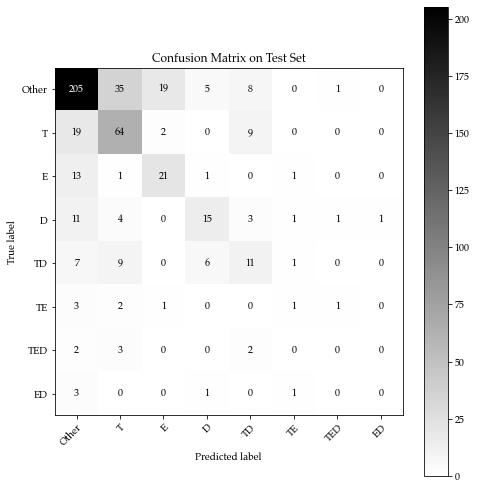

In [36]:
plot_confusion_matrix(best_model, X_test, y_test, label_tokenizer)
# plt.savefig('Confusion Matrix')

## Precision Recall Accuracy F1-Score Analysis

In [37]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [38]:
def plot_scores_graph(model, X, y, label_tokenizer):
    test_pred = np.argmax(model.predict(X), axis=1)
    cm = confusion_matrix(y, test_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    precision, recall, _, _ = score(y, test_pred)
    accuracy = cm.diagonal()
    f1 = f1_score(y, test_pred, average=None)
    label_map = {v-1: k for k, v in label_tokenizer.word_index.items()
                 }  # Need the dict
    class_names = [label_map[i] for i in range(8)]
    class_names = ["Other" if name == "other" else name.upper()
                   for name in class_names]
    accuracy = list(map(lambda x: int(round(x, 0)), accuracy*100))
    precision = list(map(lambda x: int(round(x, 0)), precision*100))
    recall = list(map(lambda x: int(round(x, 0)), recall*100))
    f1 = list(map(lambda x: int(round(x, 0)), f1*100))
    x = np.arange(len(class_names))  # the label locations
    width = 0.21
    fig, ax = plt.subplots()
    ax.set_ylim(top=100)
    rects1 = ax.bar(x - 2*width, accuracy, width, label='Accuracy')
    rects2 = ax.bar(x - width, precision, width, label='Precision')
    rects3 = ax.bar(x, recall, width, label='Recall')
    rects4 = ax.bar(x + width, f1, width, label='F1')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score (%)')
    ax.set_title('Classification metric scores by TED label')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    fig.tight_layout()
    plt.show()

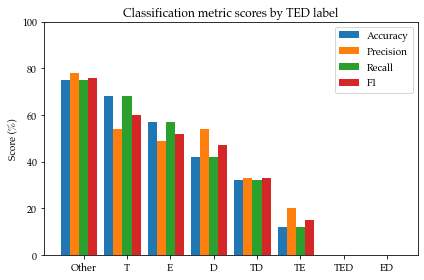

In [39]:
plot_scores_graph(best_model, X_test, y_test, label_tokenizer)